# Runtime optimization with cost handling
## Load baseline and approach data

We load data from two cases: 
1. baseline scenario: 5 steps of BOGP, 5000 samples of trip overhead per step 
2. approach: 5 steps of BOGP, split into two stages: 
    * fist stage: 3 steps of BOGP, 5000 samples of trip overhead per step
    * second stage: 2 steps of BOGP, 5000 samples of trip overhead per step

In [11]:
%matplotlib inline
%reload_ext autoreload
from rtxlib.rtx_run import setup_database, db
from factorial_anova_analysis import get_raw_data

index_baseline = "BOGP-baseline-5steps-300_regular_cars-300_smart_cars" 
index_approach_stage1 = "BOGP-approach-5steps-stage1-300_regular_cars-300_smart_cars"
index_approach_stage2 = "BOGP-approach-5steps-stage2-300_regular_cars-300_smart_cars"

results_baseline = get_raw_data(index_baseline, False)
results_approach_stage1 = get_raw_data(index_approach_stage1, False)
results_approach_stage2 = get_raw_data(index_approach_stage2, False)

data retrieved from file BOGP-baseline-5steps-300_regular_cars-300_smart_cars.pickle
data retrieved from file BOGP-approach-5steps-stage1-300_regular_cars-300_smart_cars.pickle
data retrieved from file BOGP-approach-5steps-stage2-300_regular_cars-300_smart_cars.pickle


## Display statistics on baseline scenario data

Running the baseline scenario yields the following "raw" RTX output (also in "results-CrowdNav/raw_data" folder).

In the code snippet below we print some statistics on the generated dataset.
```
Running rtx on target system with name: CrowdNav-0

######################################
Workflow       | AWD6CEOLSJ533gDbr19_
KafkaProducer  | JSON | URI: exp1:9092 | Topic: crowd-nav-commands-0
KafkaConsumer  | JSON | URI: exp1:9092 | Topic: crowd-nav-trips-0
ExecStrategy   | SelfOptimizer
Optimizer      | gauss

KnobValues     | {'re_route_every_ticks': 63, 'freshness_cut_off_value': 359, 'max_speed_and_length_factor': 2.3643285696975598, 'exploration_percentage': 0.19508109229406423, 'freshness_update_factor': 15, 'route_random_sigma': 0.11615606716272785, 'average_edge_duration_factor': 1.2081011415096372}


Statistics     | 1/5 took 525261ms - remaining ~3151sec
FullState      | {'data_points': 5000, 'avg_overhead': 1.8385592176489332, 'issued_complaints': 0}
ResultValue    | 1.83855921765

KnobValues     | {'re_route_every_ticks': 70, 'freshness_cut_off_value': 100, 'max_speed_and_length_factor': 1.0, 'exploration_percentage': 0.0, 'freshness_update_factor': 20, 'route_random_sigma': 0.29999999999999999, 'average_edge_duration_factor': 2.5}


Statistics     | 2/5 took 594542ms - remaining ~2972sec
FullState      | {'data_points': 5000, 'avg_overhead': 2.1320990516920046, 'issued_complaints': 0}
ResultValue    | 2.13209905169

KnobValues     | {'re_route_every_ticks': 10, 'freshness_cut_off_value': 100, 'max_speed_and_length_factor': 1.4945493929158853, 'exploration_percentage': 0.050102688626504112, 'freshness_update_factor': 5, 'route_random_sigma': 0.11183409046143469, 'average_edge_duration_factor': 1.2009325180672086}


Statistics     | 3/5 took 1190567ms - remaining ~4762sec
FullState      | {'data_points': 5000, 'avg_overhead': 1.8661121418152593, 'issued_complaints': 0}
ResultValue    | 1.86611214182

KnobValues     | {'re_route_every_ticks': 70, 'freshness_cut_off_value': 100, 'max_speed_and_length_factor': 1.4899304724142679, 'exploration_percentage': 0.046671921875090533, 'freshness_update_factor': 5, 'route_random_sigma': 0.1457615546536177, 'average_edge_duration_factor': 2.3289187877357223}

Statistics     | 4/5 took 535051ms - remaining ~1605sec
FullState      | {'data_points': 5000, 'avg_overhead': 1.9043303904391287, 'issued_complaints': 0}
ResultValue    | 1.90433039044

KnobValues     | {'re_route_every_ticks': 70, 'freshness_cut_off_value': 100, 'max_speed_and_length_factor': 2.5, 'exploration_percentage': 0.29999999999999999, 'freshness_update_factor': 5, 'route_random_sigma': 0.0, 'average_edge_duration_factor': 2.5}


Statistics     | 5/5 took 521958ms - remaining ~1043sec <br>
FullState      | {'data_points': 5000, 'avg_overhead': 1.8815013325965564, 'issued_complaints': 0}
ResultValue    | 1.8815013326

OptimalResult  | Knobs:  {'re_route_every_ticks': 63, 'freshness_cut_off_value': 359, 'max_speed_and_length_factor': 2.3643285696975598, 'exploration_percentage': 0.19508109229406423, 'freshness_update_factor': 15, 'route_random_sigma': 0.11615606716272785, 'average_edge_duration_factor': 1.2081011415096372}
               | Result: 1.83855921765

Simulation finished
```

In [12]:
import pprint
from IPython.display import Markdown, display

def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
    
pp = pprint.PrettyPrinter(indent=4)

best_knob = {
    u'average_edge_duration_factor': 1.2081011415096372,
    u'exploration_percentage': 0.19508109229406423,
    u'freshness_cut_off_value': 359,
    u'freshness_update_factor': 15,
    u'max_speed_and_length_factor': 2.36432856969756,
    u're_route_every_ticks': 63,
    u'route_random_sigma': 0.11615606716272785
}

knobs = {}
data = {}
for r in results_baseline:
    knob_str = str(r[1])
    if not knob_str in knobs:        
        knobs[knob_str] = []
    if len(knobs[knob_str]) < 5000:
        knobs[knob_str].append(r[1])
    if not knob_str in data:        
        data[knob_str] = []
    if len(data[knob_str]) < 5000:
        data[knob_str].append(r[0])

printmd("**Found " + str(len(knobs)) + " different configurations in " \
        + str(len(results_baseline)) + " data in baseline **", "green")

i = 1
for k in knobs:
    print "Configuration #" + str(i) + " (" + str(len(knobs[k])) + " data points):"
    i += 1
    pp.pprint(eval(k))
    print "\n"

printmd("**Best configuration reported by the BOGP in baseline**", "red")
pp.pprint(knobs[str(best_knob)][0])

<span style='color:green'>**Found 5 different configurations in 25000 data in baseline **</span>

Configuration #1 (5000 data points):
{   u'average_edge_duration_factor': 1.2009325180672086,
    u'exploration_percentage': 0.05010268862650411,
    u'freshness_cut_off_value': 100,
    u'freshness_update_factor': 5,
    u'max_speed_and_length_factor': 1.4945493929158853,
    u're_route_every_ticks': 10,
    u'route_random_sigma': 0.1118340904614347}


Configuration #2 (5000 data points):
{   u'average_edge_duration_factor': 2.3289187877357223,
    u'exploration_percentage': 0.04667192187509053,
    u'freshness_cut_off_value': 100,
    u'freshness_update_factor': 5,
    u'max_speed_and_length_factor': 1.489930472414268,
    u're_route_every_ticks': 70,
    u'route_random_sigma': 0.1457615546536177}


Configuration #3 (5000 data points):
{   u'average_edge_duration_factor': 2.5,
    u'exploration_percentage': 0.3,
    u'freshness_cut_off_value': 100,
    u'freshness_update_factor': 5,
    u'max_speed_and_length_factor': 2.5,
    u're_route_every_ticks': 70,
    u'route_random_sigma': 0

<span style='color:red'>**Best configuration reported by the BOGP in baseline**</span>

{   u'average_edge_duration_factor': 1.2081011415096372,
    u'exploration_percentage': 0.19508109229406423,
    u'freshness_cut_off_value': 359,
    u'freshness_update_factor': 15,
    u'max_speed_and_length_factor': 2.36432856969756,
    u're_route_every_ticks': 63,
    u'route_random_sigma': 0.11615606716272785}


## Plotting the results of the baseline scenario

For each step of the BOGP, we plot a boxplot with the obtained trip overhead values. 

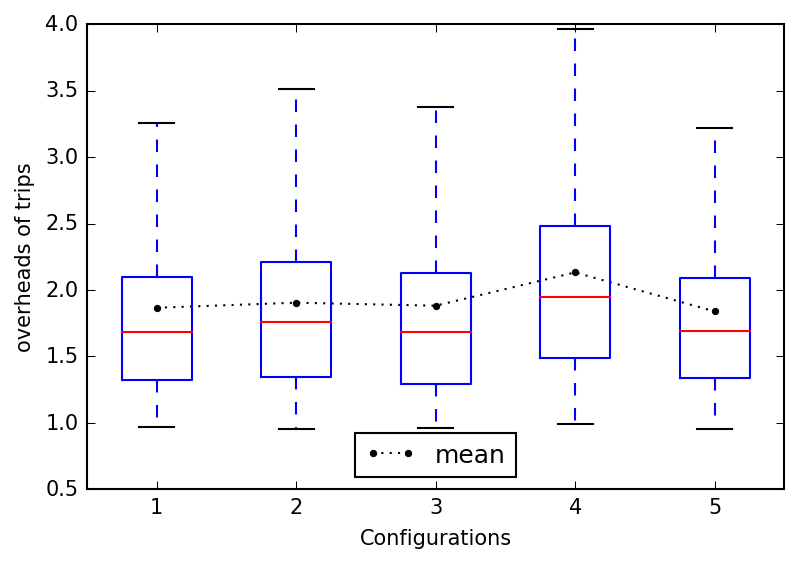

In [13]:
import matplotlib.pyplot as plt
from numpy import var, std, mean, median
import matplotlib as mpl
mpl.rc("savefig", dpi=150)

y_key = 'overhead'

means = []
all_data = []

knob_labels = range(1,6)

for k in knobs:
    analysis_data = [r[y_key] for r in data[k]]
    all_data.append(analysis_data)
    means.append(mean(analysis_data))

fig,ax = plt.subplots()
ax.plot(knob_labels,means, ".", label='mean', color="black", linestyle=":")
ax.boxplot(all_data, 0, '', positions=knob_labels)
plt.xticks(knob_labels, ["1", "2", "3", "4", "5"])
plt.legend(loc='lower center')
plt.ylabel('overheads of trips')
plt.xlabel('Configurations')
plt.show()

## Display statistics on approach data

Running our 2-stage approach yields the two following "raw" RTX outputs (also in "results-CrowdNav/raw_data" folder).

In the code snippet below we print some statistics on the generated dataset.

Raw ouput #1:
```
OEDA configuration: Using elasticsearch database.
Running rtx on target system with name: CrowdNav-0

######################################
Workflow       | AWEDseBPSJ533gDbr1-6
KafkaProducer  | JSON | URI: exp1:9092 | Topic: crowd-nav-commands-0
KafkaConsumer  | JSON | URI: exp1:9092 | Topic: crowd-nav-trips-0
ExecStrategy   | SelfOptimizer
Optimizer      | gauss

KnobValues     | {'freshness_cut_off_value': 478}


Statistics     | 1/2 took 1191378ms - remaining ~3574sec
FullState      | {'data_points': 5000, 'avg_overhead': 1.8141848587402314, 'issued_complaints': 0}
ResultValue    | 1.81418485874

KnobValues     | {'freshness_cut_off_value': 700}


Statistics     | 2/2 took 1103475ms - remaining ~2206sec
FullState      | {'data_points': 5000, 'avg_overhead': 1.7968787922745082, 'issued_complaints': 0}
ResultValue    | 1.79687879227

OptimalResult  | Knobs:  {'freshness_cut_off_value': 700}
                | Result: 1.79687879227

Simulation finished
```

Raw ouput #2:
```
Running rtx on target system with name: CrowdNav-0

######################################
Workflow       | AWEACkN2SJ533gDbr1-t
KafkaProducer  | JSON | URI: exp1:9092 | Topic: crowd-nav-commands-0
KafkaConsumer  | JSON | URI: exp1:9092 | Topic: crowd-nav-trips-0
ExecStrategy   | SelfOptimizer
Optimizer      | gauss

KnobValues     | {'max_speed_and_length_factor': 1.2218451599199196}


Statistics     | 1/3 took 1150608ms - remaining ~4602sec
FullState      | {'data_points': 5000, 'avg_overhead': 1.7941747631251665, 'issued_complaints': 0}
ResultValue    | 1.79417476313

KnobValues     | {'max_speed_and_length_factor': 2.5}


Statistics     | 2/3 took 1155665ms - remaining ~3466sec
FullState      | {'data_points': 5000, 'avg_overhead': 1.8445119417292688, 'issued_complaints': 0}
ResultValue    | 1.84451194173

KnobValues     | {'max_speed_and_length_factor': 1.0}


Statistics     | 3/3 took 1143805ms - remaining ~2287sec
FullState      | {'data_points': 5000, 'avg_overhead': 1.814173232203285, 'issued_complaints': 0}
ResultValue    | 1.8141732322

OptimalResult  | Knobs:  {'max_speed_and_length_factor': 1.2218451599199196}
                | Result: 1.79417476313

Simulation finished
```

In [16]:
best_knob_appr1 = {u'max_speed_and_length_factor': 1.2218451599199196}

knobs1 = {}
data1 = {}
for r in results_approach_stage1:
    knob_str = str(r[1])
    if not knob_str in knobs1:        
        knobs1[knob_str] = []
    if len(knobs1[knob_str]) < 5000:
        knobs1[knob_str].append(r[1])
    if not knob_str in data1:        
        data1[knob_str] = []
    if len(data1[knob_str]) < 5000:
        data1[knob_str].append(r[0])

printmd("**Found " + str(len(knobs1)) + " different configurations in " \
        + str(len(results_approach_stage1)) + " data in stage 1 **", "green")

i = 1
for k in knobs1:
    print "Configuration #" + str(i) + " (" + str(len(knobs1[k])) + " data points):"
    i += 1
    pp.pprint(eval(k))
    print "\n"

printmd("**Best configuration reported by the BOGP in stage 1**", "red")
pp.pprint(knobs1[str(best_knob_appr1)][0])
print "\n"

best_knob_appr2 = {u'freshness_cut_off_value': 700}

b_knobs = {}
b_data = {}
for r in results_approach_stage2:
    knob_str = str(r[1])
    if not knob_str in b_knobs:        
        b_knobs[knob_str] = []
    if len(b_knobs[knob_str]) < 5000:
        b_knobs[knob_str].append(r[1])
    if not knob_str in b_data:        
        b_data[knob_str] = []
    if len(b_data[knob_str]) < 5000:
        b_data[knob_str].append(r[0])

printmd("**Found " + str(len(b_knobs)) + " different configurations in " \
        + str(len(results_approach_stage2)) + " data in stage 2 **", "green")

i = 1
for k in b_knobs:
    print "Configuration #" + str(i) + " (" + str(len(b_knobs[k])) + " data points):"
    i += 1
    pp.pprint(eval(k))
    print "\n"

printmd("**Best configuration reported by the BOGP in stage 2**", "red")
pp.pprint(b_knobs[str(best_knob_appr2)][0])

<span style='color:green'>**Found 3 different configurations in 15000 data in stage 1 **</span>

Configuration #1 (5000 data points):
{   u'max_speed_and_length_factor': 2.5}


Configuration #2 (5000 data points):
{   u'max_speed_and_length_factor': 1.0}


Configuration #3 (5000 data points):
{   u'max_speed_and_length_factor': 1.2218451599199196}




<span style='color:red'>**Best configuration reported by the BOGP in stage 1**</span>

{   u'max_speed_and_length_factor': 1.2218451599199196}




<span style='color:green'>**Found 2 different configurations in 10000 data in stage 2 **</span>

Configuration #1 (5000 data points):
{   u'freshness_cut_off_value': 478}


Configuration #2 (5000 data points):
{   u'freshness_cut_off_value': 700}




<span style='color:red'>**Best configuration reported by the BOGP in stage 2**</span>

{   u'freshness_cut_off_value': 700}


## Plotting the results of the 2-stage approach

For each step of the BOGP, we plot a boxplot with the obtained trip overhead values. 

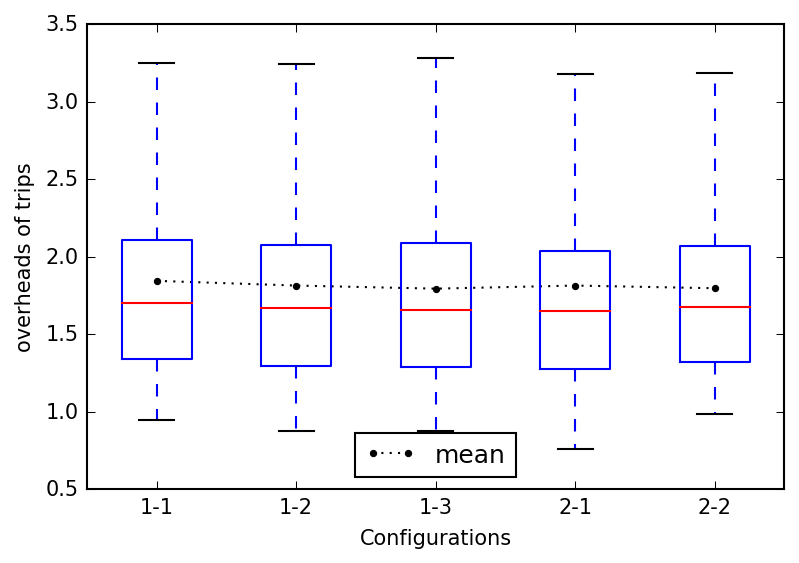

In [17]:
means2 = []
all_data = []

knob_labels = []
i = 0
for k in knobs1: 
    knob_labels.append(i)
    i += 1

for k in sorted(b_knobs): 

    knob_labels.append(i)
    i += 1

for k in knobs1:
    analysis_data = [r[y_key] for r in data1[k]]
    all_data.append(analysis_data)
    means2.append(mean(analysis_data))

for k in sorted(b_knobs):
    analysis_data = [r[y_key] for r in b_data[k]]
    all_data.append(analysis_data)
    means2.append(mean(analysis_data))
    
fig,ax = plt.subplots()
ax.plot(knob_labels,means2, ".", label='mean', color="black", linestyle=":")
ax.boxplot(all_data, 0, '', positions=knob_labels)
plt.xticks(knob_labels, ["1-1", "1-2", "1-3", "2-1", "2-2"])
plt.legend(loc='lower center')
plt.ylabel('overheads of trips')
plt.xlabel('Configurations')
plt.show()

## Comparing approach to baseline scenario

### Comparison #1: Visual comparison of evalution of means in the BOGP in the two cases

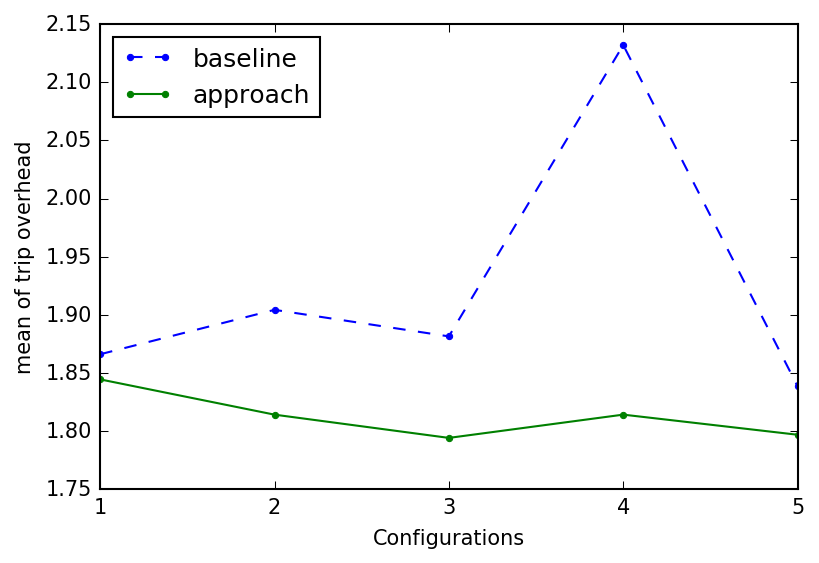

In [18]:
knob_labels = range(5)
fig,ax = plt.subplots()
ax.plot(knob_labels, means, ".", label='baseline', linestyle="--")
ax.plot(knob_labels, means2, ".", label='approach', linestyle="-")
plt.xticks(knob_labels, ["1", "2", "3", "4", "5"])
plt.legend(loc='best')
plt.ylabel('mean of trip overhead')
plt.xlabel('Configurations')
plt.show()

### Comparison #2: Performing t-test between the best configuration of the baseline and the best configuration of the approach

The result shows that the best configuration of the approach is statistically significant better (a<0.05) than the baseline scenario.

In [19]:
from analysis_lib.two_sample_tests import Ttest
from analysis_lib.two_sample_tests import TtestPower
from complaints_generator import generate_complaints
from scipy.stats import binom_test
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc("savefig", dpi=150)
import random 
from IPython.display import Markdown, display

def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
    
random.seed(123456)

knobs2 = b_knobs.copy()
data2 = b_data.copy()

b_knobs[str(best_knob)] = knobs[str(best_knob)]
b_data[str(best_knob)] = data[str(best_knob)]

y_key = 'overhead'
alpha = 0.05
necessary_power = 0.80

fake_run_id = "123456"

knob_values = list(reversed(b_knobs.keys()))
best_knob2 = knob_values[0]
other_knob_values = knob_values[1:] 

pvalues = {}
powers = {}

for i in knob_values:
    pvalues[i] = []
    powers[i] = []
        
step = 100

count = 0
sample_size = 5000

for other_knob_value in other_knob_values:   
    analysis_data = {}
    raw_data = b_data[best_knob2] 
    analysis_data[0] = random.sample(raw_data, sample_size)

    raw_data = b_data[other_knob_value] 
    analysis_data[1] = random.sample(raw_data, sample_size)

    t = Ttest(fake_run_id, y_key, alpha).start(analysis_data, {})
    pvalues[other_knob_value].append(t["pvalue"])
    one_sided_p_value = t["pvalue"]/2

    if t["statistic"] < 0:
        t_p = TtestPower(fake_run_id, y_key, t["effect_size"], alpha, 'smaller').start(analysis_data, {})            
    else: 
        t_p = TtestPower(fake_run_id, y_key, t["effect_size"], alpha, 'larger').start(analysis_data, {})            
    powers[other_knob_value].append(t_p["power"])

    if one_sided_p_value < alpha:# and t_p["power"] >= necessary_power:
        printmd("**SIGNIFICANT DIFFERENCE**", "green")
        different = "smaller" if t["statistic"] < 0 else "larger"
        print "sample size: " + str(sample_size) 
        print "================"
        print "Overhead in " 
        pp.pprint(eval(best_knob2))
        print " is " + different + " than in "
        pp.pprint(eval(other_knob_value))
        print "================"
        print "mean difference: " + str(t["mean_diff"]) 
        print "p value: " + str(one_sided_p_value)                                 
        print "effect size (Cohen's d): " + str(t["effect_size"]) 
        print "statistical power: " + str(t_p["power"])
        print "\n"

        count += 1
        if t["statistic"] >= 0:
            best_knob2 = other_knob_value
        break

    if sample_size == 5000:
        printmd("**NO SIGNIFICANT DIFFERENCE**", "red")
        different = "smaller" if t["statistic"] < 0 else "larger"
        print "sample size: " + str(sample_size) 
        print "================"
        print "Overhead in " 
        pp.pprint(eval(best_knob2))
        print " is " + different + " than in "
        pp.pprint(eval(other_knob_value))
        print "================"
        print "mean difference: " + str(t["mean_diff"]) 
        print "p value: " + str(one_sided_p_value)                                 
        print "effect size (Cohen's d): " + str(t["effect_size"]) 
        print "statistical power: " + str(t_p["power"])
        print "\n"
    break


with log transformation...
with log transformation...


<span style='color:green'>**SIGNIFICANT DIFFERENCE**</span>

sample size: 5000
Overhead in 
{   u'average_edge_duration_factor': 1.2081011415096372,
    u'exploration_percentage': 0.19508109229406423,
    u'freshness_cut_off_value': 359,
    u'freshness_update_factor': 15,
    u'max_speed_and_length_factor': 2.36432856969756,
    u're_route_every_ticks': 63,
    u'route_random_sigma': 0.11615606716272785}
 is larger than in 
{   u'freshness_cut_off_value': 700}
mean difference: 0.0145181934569
p value: 0.012926784536
effect size (Cohen's d): 0.0445792078318
statistical power: 0.720375024243




### Comparison #3: Visual comparison of best configuration of baseline and best configuration of approach in box plots 

Due to the small effect size, the difference reported by the t-test is not visible in box plots.

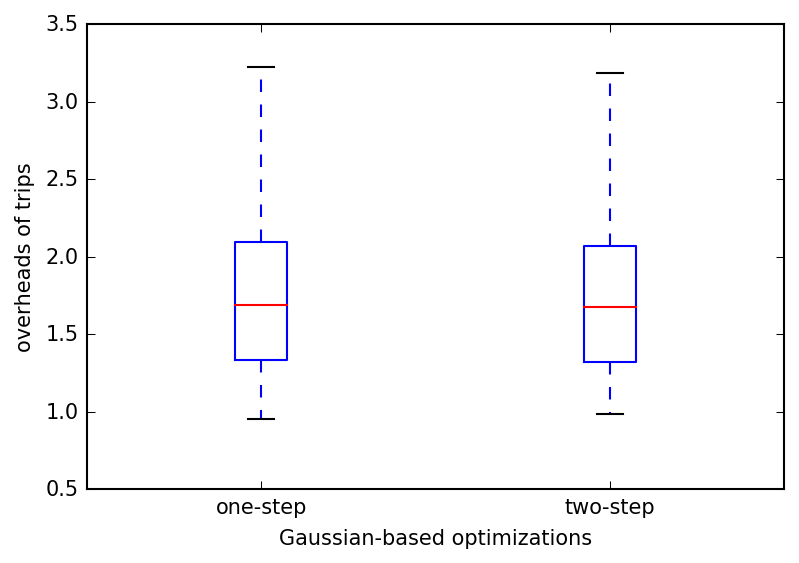

In [20]:
all_data = []

analysis_data = [r[y_key] for r in data[str(best_knob)]]
all_data.append(analysis_data)

analysis_data = [r[y_key] for r in data2[best_knob2]]
all_data.append(analysis_data)
    
knob_labels = ["one-step", "two-step"]
arithmetic_labels = [0,1]
fig,ax = plt.subplots()
ax.boxplot(all_data, 0, '', positions=arithmetic_labels)
plt.xticks(arithmetic_labels, knob_labels)
plt.legend(loc='best')
plt.ylabel('overheads of trips')
plt.xlabel('Gaussian-based optimizations')
plt.show()

## Supplementary: looking at trip overhead distributions

These are some visual statistics we performed to check the distribution of trip overheads. 
In order to bring it closer to normal distribution (and thus perform t-test with increased validity), we applied a logarithmic distribution on the trip overhead values (resulting in a ditribution closer to normal, we can be observed in the second diagram) before performing the above t-test.

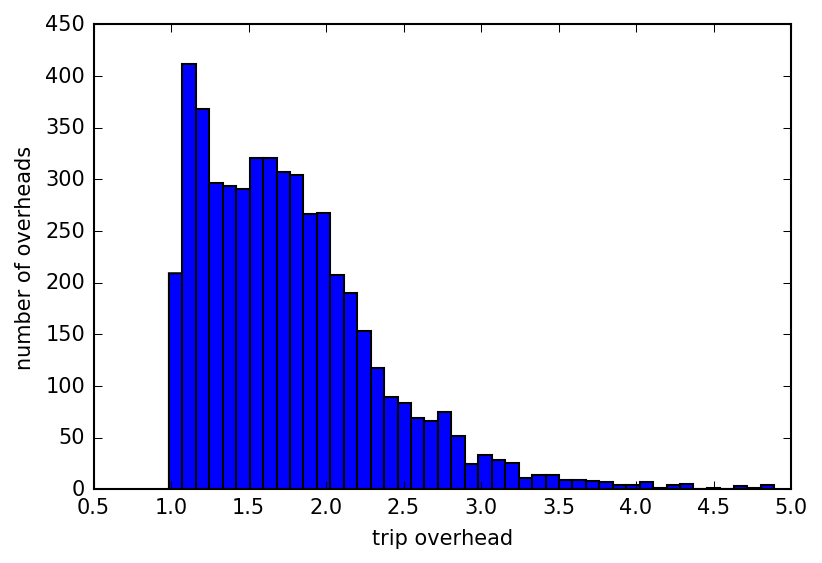

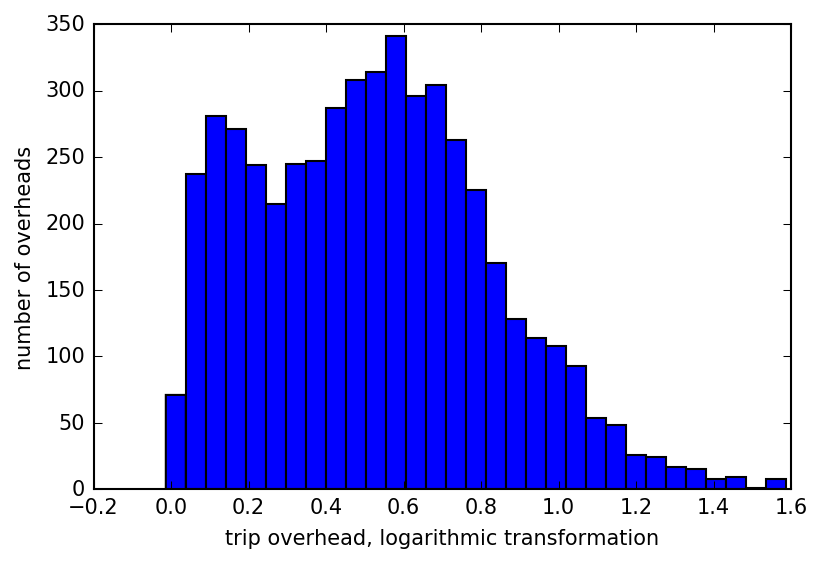

In [21]:
from math import log

analysis_data = [r[y_key] for r in data2[best_knob2] if r[y_key] < 5]

import matplotlib.pyplot as plt
plt.hist(analysis_data, bins='auto')  
plt.ylabel('number of overheads')
plt.xlabel('trip overhead')
plt.show()

analysis_data = [log(r[y_key]) for r in data2[best_knob2] if r[y_key] < 5]

import matplotlib.pyplot as plt
plt.hist(analysis_data, bins='auto')  
plt.ylabel('number of overheads')
plt.xlabel('trip overhead, logarithmic transformation')
plt.show()